In [43]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import trim_mean
import random
sns.set_style("whitegrid")

In [11]:
df = pd.read_csv("files/data.csv")
not_important = ['id','uri','track_href','analysis_url','duration_ms','type']
dfc = df.drop(columns=not_important)

In [1]:
# Statistical inference pipeline
# Formulate hypothesis -> Design experiment -> Collect data -> Inference/Conclusion

In [3]:
# A/B testing
# Subjects assigned to a group or other.Subjects are randomized assigned to each group, so the difference between two groups is because
# - Effect of treatment
# - "Luck" in draw
# Without control group, there is no certain that all others things remained the same.

In [4]:
# Hypothesis test
# Null hypothesis -> Treatment era equivalent -> Prove it wrong and show that difference is not due to chance
# Alternate hypothesis -> Thing we want evideence for
# Resampling permutation -> 
# Shuffle together A and B groups,and repeatedly deal out the data in groups of similar sizes, and observe how many times the difference is as extreme as the observed difference

In [5]:
# One Way/ Two way
# Bidirectional -> Two way -> Different
# Unidirectional -> One way -> Smaller or greater


In [6]:
# Resampling 
# Bootstrap -> Variability in a estimate
# Permutation test -> Test hypothesis, involving two or more groups

In [44]:
# Permutation test
# 1.Combine results from different groups in a dataset
# 2.Shuffle the combined data and randomly draw(without replacement) a resample of the same size as group A 
# 3. From the remaining data, draw a resample of size B
# 4. Calculate the statistic for the original samples (ex. difference in means), calculate if for the resamples and record
# 5. Repeat it R times
# 6. Get the observed difference between groups and compare it to the set of permutaed differences
# If the observed difference lies well within the set of permutation differences, the observed difference is within the range that we might produce.
# Else, if the observed difference lies outside most of the permutation distribution, we conclude that this is not by chance. Its statistically significant

In [45]:
garage_energy = dfc[dfc['genre']=='garage']['energy']
chill_energy = dfc[dfc['genre']=='chill']['energy']

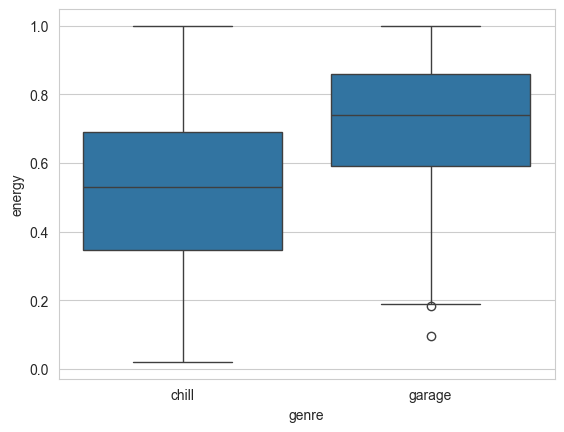

In [46]:
df_test = dfc[dfc['genre'].isin(['garage','chill'])]
_ = sns.boxplot(x='genre',y='energy',data=df_test)

In [17]:
observed_difference = garage_energy.mean() - chill_energy.mean()
print(f"Observed diff : {observed_difference}")

Observed diff : 0.1885251000000001


In [30]:
ngarage,nchill = len(garage_energy), len(chill_energy)
combined = pd.concat([garage_energy,chill_energy],ignore_index=True)

In [40]:
def permutation_test(x,na,nb):
    n = na + nb
    idx_B = set(random.sample(range(n),nb))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_A)].mean() -  x.loc[list(idx_B)].mean()

In [41]:
perm_diffs = [permutation_test(combined, ngarage, nchill) for _ in range(1000)]

Text(0.15, 180, 'Observed\ndifference')

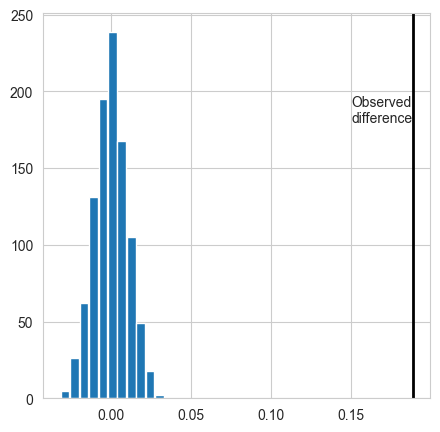

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = observed_difference, color='black', lw=2)
ax.text(0.15, 180, 'Observed\ndifference')

In [47]:
(observed_difference > perm_diffs).mean()

1.0

In [ ]:
## Boostrap test 
# Like permutation test, but is done with replacement.

In [52]:
# Statistical tests

#  We can estimate a pvalue from our permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference
# pvalue - >The probability that, given a chance model, results as extreme as the observed results could occur.

# Type 1 error -> Mistankenly conclude an effect is real
# Type 2 error -> Mistankely conclude an effect is not real

In [53]:
# Degrees of freedom
# Number of values free to vary
# n-1, n sample size (If you know the mean from 10 values,is 9, because  the 10th can be calculated)

In [55]:
# ANOVA
# Comparison of multiple groups
# Combine all data in a single box
# Shuffle and draw out n_groups resamples of size ni for each group i
# Record the mean for each group
# Record the variance among the four group means
# Repeat for R steps

In [64]:
ANOVA = df[['genre','energy']]

In [65]:
observed_variance = ANOVA.groupby("genre")['energy'].mean().var()
print(f"Observed means {ANOVA.groupby('genre')['energy'].mean()}")
print('Variance:', observed_variance)

def anova(df,c='energy'):
    df_ = df.copy()
    df_[c] = np.random.permutation(df_[c])
    return df_.groupby("genre").mean().var()

Observed means genre
chill        0.519152
garage       0.707677
hard-rock    0.767888
indie-pop    0.565869
pop          0.626116
Name: energy, dtype: float64
Variance: 0.010298152775733


In [67]:
perm_variance = [anova(ANOVA) for _ in range(1000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Pr(Prob) 0.0


In [71]:
# Chi-square
# Used with count data to check how well it fits to a expected distribution
df_cs = pd.DataFrame(data=[[14,8,12],[986,992,988]],columns=['A','B','C'],index=['Click','No Click'])
df_cs

,A,B,C
Click,14,8,12
No Click,986,992,988


In [73]:
box = [1] * df_cs.loc['Click'].sum()
box.extend([0] * df_cs.loc['No Click'].sum())

def chi_square(observed,expected):
    
    pearson_residuals = []
    for row,expect in zip(observed,expected):
        pearson_residuals.append([(observe - expect)**2/expect for observe in row])
    return np.sum(pearson_residuals)

In [78]:
expected_clicks = df_cs.loc['Click'].sum() / 3
expected_noclicks = 1000 - expected_clicks  
expected = [expected_clicks, expected_noclicks]
chi2observed = chi_square(df_cs.values, expected)

In [80]:
def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi_square([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4595
